# Classifiez automatiquement des biens de consommation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
import os
import shutil
import re
from zipfile import ZipFile
from os import listdir
from pathlib import Path
from functools import reduce
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,plot_confusion_matrix

import sklearn.metrics as metrics
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import intercluster_distance
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn import cluster

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from sklearn import decomposition, preprocessing
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

stemmer    = EnglishStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA

import cv2

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix

pd.set_option("display.precision", 2)          
pd.set_option("display.max.columns", None)    
pd.set_option("display.max.rows", None)

import warnings
warnings.simplefilter(action='ignore', category=Warning)

[nltk_data] Downloading package stopwords to /home/yonss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yonss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yonss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Extraction  des donnees

In [2]:
dir_data = Path('../../DATA/P6') 
dir_fig  = Path('../../FIGURE/P6')
work_dir=os.getcwd()
CHECK_FOLDER  = Path('../../DATA/P6/Flipkart') 

if CHECK_FOLDER.exists():
    print ("Fichier existe") 
else:
    for dirname, _, filenames in os.walk(dir_data):
        for filename in filenames:
            file_in=os.path.join(dirname, filename)
            print(file_in)
            with ZipFile(file_in, 'r') as zip:
                zip.extractall(dir_data)
#
print(os.listdir(CHECK_FOLDER))

Fichier existe
['Images', 'flipkart_com-ecommerce_sample_1050.csv']


Le dataset est constitue d'un fichier en format .csv et des images en format .jpg (Les images sont dans le dossier Images).
On va d'abord analyser les information contenue dans le fichier .csv

# Classification d'articles basé sur une description des article

## Description des donnees contenue dans le fichier .csv

In [3]:
list_files = [file for file in listdir(CHECK_FOLDER)]
files=[]
for f in os.listdir(CHECK_FOLDER):
    if f.endswith('.csv'):
        files.append(os.path.join(CHECK_FOLDER,f))
        if len(files)==1:
            df =pd.read_csv(files[0])
        else:
            print('ATT: Regarde les donnees')

In [4]:
df.shape

(1050, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
df_null = df.isnull().sum()
df_null

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [7]:
df_null[0]

0

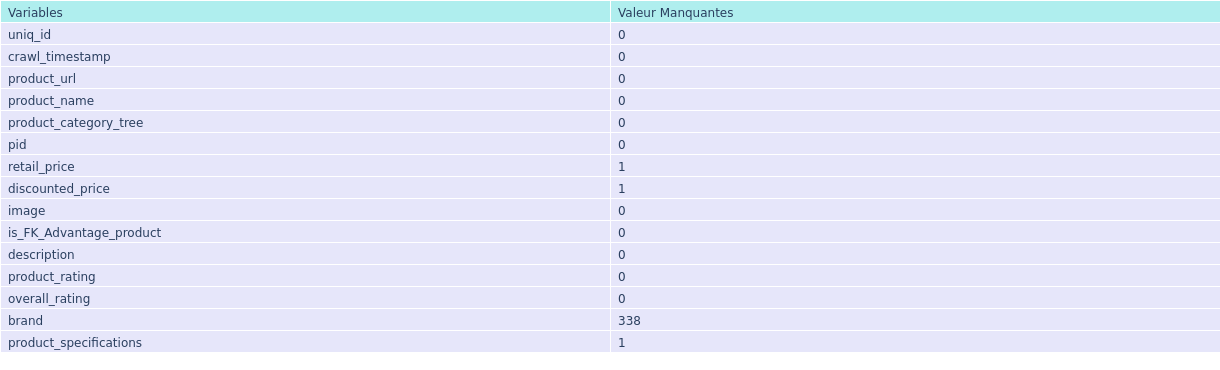

In [8]:
toplop=df_null
colplot=['Variables','Valeur Manquantes']
dss=22

import plotly.graph_objects as go
plt.rc('font', size=15)
fig = go.Figure(data=[go.Table(
    columnwidth = [10,10],
    header=dict(values=list(colplot),
                fill_color='paleturquoise',
                align='left',
                height=dss),
    cells=dict(values=[df_null.index, toplop],
               fill_color='lavender',
               align='left',
               height=dss))
])
fig.update_layout(height=370,width=280,margin=dict(t=0,b=0,l=0,r=0))
fig.show()

figure_name='val_manq.jpeg'
fig.write_image(figure_name)


!cp val_manq.jpeg  /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv val_manq.jpeg   /home/yonss/Data_Scientist/FIGURE/P6

La majeure partie des variables sont catégorielles. Deux variables uniquement sont des numériques.

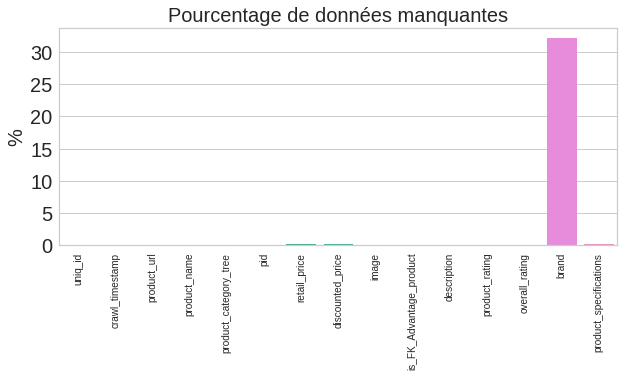

In [9]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("",fontsize=20)
plt.ylabel("%",fontsize=20)
plt.title("Pourcentage de données manquantes",fontsize=20)
plt.rc('font', size=20 ) 
plt.yticks(fontsize=20) 
figure_name='data_manq.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp data_manq.jpeg /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv data_manq.jpeg  /home/yonss/Data_Scientist/FIGURE/P6

In [10]:
define_max_acepteble_nan= 4     # 4 c'est 1/4 de NaN or Nul
print(len(df)/define_max_acepteble_nan)
for col_name in df.columns:
    if df_null[col_name]>0:
        if df_null[col_name]>len(df)/define_max_acepteble_nan:
            print(col_name,df_null[col_name])
            df=df.drop([col_name], axis=1)
        else:
            if df[col_name].dtypes==np.float64:
                df[col_name].fillna(value = df[col_name].mean(), inplace=True)
                print(col_name, df_null[col_name])
            else:
                df[col_name].fillna(value = 'Unknown', inplace=True)
                print(col_name, df_null[col_name])
        #


262.5
retail_price 1
discounted_price 1
brand 338
product_specifications 1


In [11]:
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0            899.00  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0            449.00  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2        2186.2           1584.53  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0           1299.00  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0            698.00  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating  \
0  No rating available  No rating available   
1  No rating available  No rating available   
2  No rating available  No rating available   
3  No rating available  No rating available   
4  No rating available  No rating available   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [12]:
df['product_category_tree'].head()

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
Name: product_category_tree, dtype: object

In [13]:
def split_cat_var(column):
    categorie = column.split('["')[1].split('"]')[0]
    cat = categorie.split(' >> ')[knx]
    return cat

for knx in range(0,1):
    name=str('Category_'+str(knx))
    print(name)
    df[name] = df['product_category_tree'].apply(split_cat_var)

Category_0


In [14]:
print(df[name].unique())

['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']


In [15]:
df[name] = df[name].str.replace(
    '&', 'and')
df[name] = df[name].str.replace(
    ' ', '_')
df[name] = df[name].str.lower()

In [16]:
print(df[name].nunique())

7


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1050 non-null   float64
 7   discounted_price         1050 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  product_specifications   1050 non-null   object 
 14  Category_0              

In [18]:
df[name].value_counts()

home_furnishing                 150
baby_care                       150
watches                         150
home_decor_and_festive_needs    150
kitchen_and_dining              150
beauty_and_personal_care        150
computers                       150
Name: Category_0, dtype: int64

<Figure size 2160x1080 with 0 Axes>

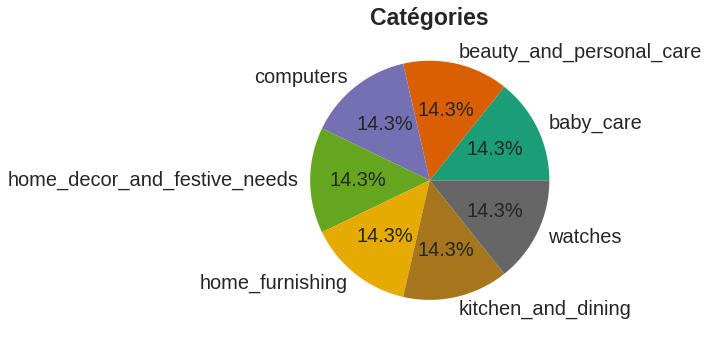

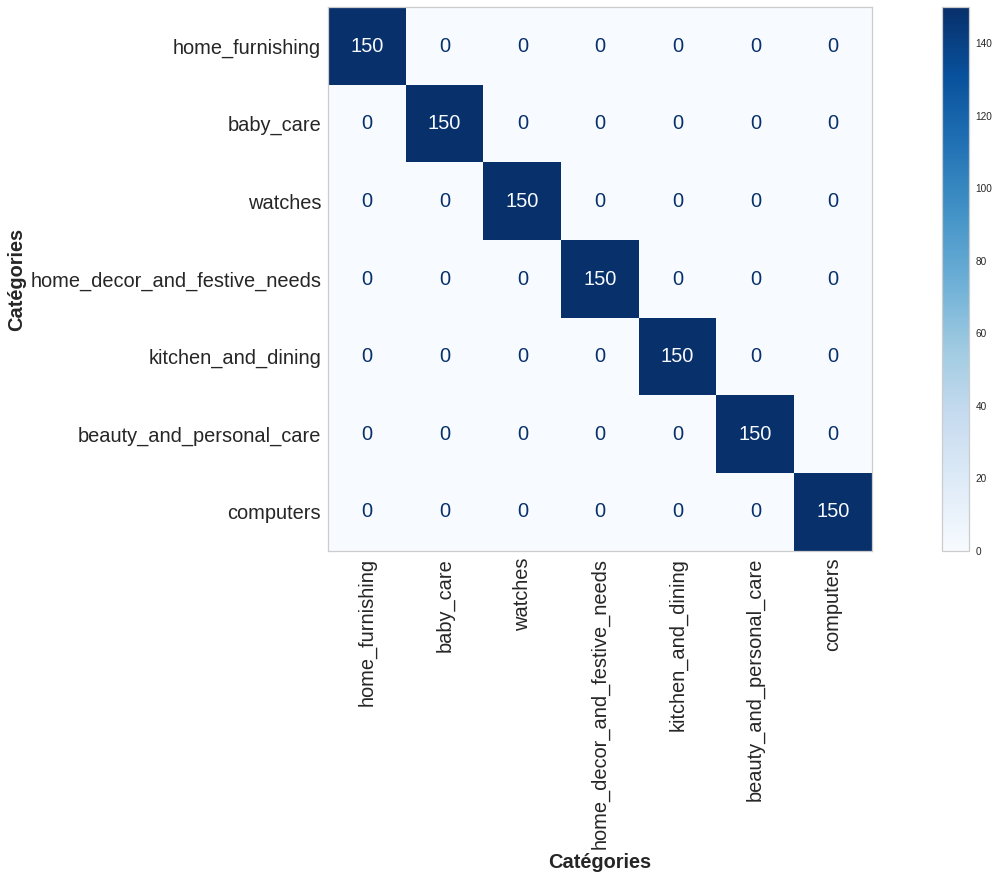

In [19]:
data_plot_0 = df.groupby(name).agg(Categories =('uniq_id','count'))
data_plot_0=data_plot_0.sort_values(by='Categories', ascending=False)
cmo = confusion_matrix(df[name], df[name])
dss=20
#f, (ax1,ax2) = plt.subplots(1,1, figsize=(25,10))
fig = plt.figure(1, figsize=(30, 15))
data_plot_0.plot(kind='pie', x=name, y='Categories', title = '', 
cmap='Dark2', autopct="%.1f%%", legend=False,fontsize=dss);
plt.title("Catégories", weight='bold', size=dss+3)

plt.xlabel("",fontsize=dss)
plt.ylabel(" ",fontsize=dss)

plt.xticks(fontsize=dss)
plt.grid(False)

plt.rc('font', size=dss ) 
plt.yticks(fontsize=dss) 
figure_name='data_avail.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp data_avail.jpeg /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv data_avail.jpeg  /home/yonss/Data_Scientist/FIGURE/P6
#----------------------------------------------------------------------
#f.subplots_adjust(left=0.1,bottom=0.1, right=1.1, top=0.9, wspace=0.4, hspace=0.4)
fig, ax2 = plt.subplots(figsize=(25,10))

cm_display = ConfusionMatrixDisplay(cmo).plot(ax=ax2,cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': dss})
ax2.set_ylabel("Catégories", weight='bold', size=dss)
ax2.set_xlabel('Catégories', weight='bold', size=dss)
ax2.set_yticklabels(df['Category_0'].unique(), size=dss)
ax2.set_xticklabels(df['Category_0'].unique(), size=dss)
plt.xticks(fontsize=dss)
plt.xticks(rotation=90)
plt.grid(False)

plt.rc('font', size=dss ) 
plt.yticks(fontsize=dss) 
figure_name='data_avail2.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp data_avail2.jpeg /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv data_avail2.jpeg  /home/yonss/Data_Scientist/FIGURE/P6


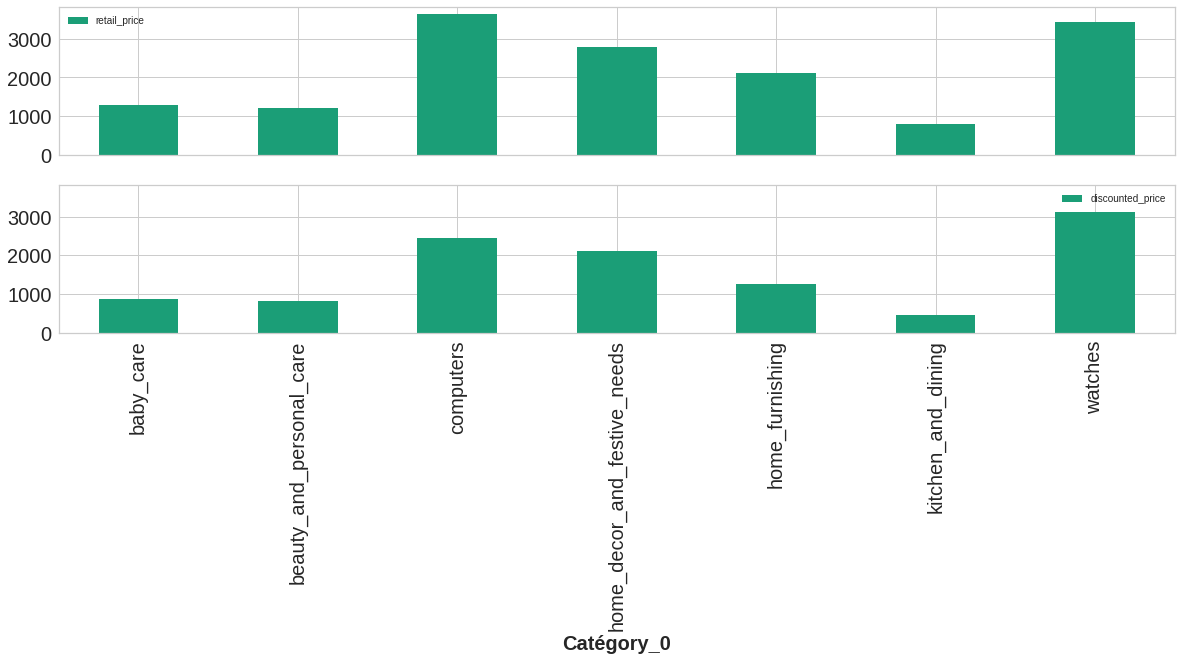

In [20]:
data_plot_1  = df.groupby(name).agg(retail_price =('retail_price','mean'))
data_plot_10 = df.groupby(name).agg(discounted_price =('discounted_price','mean'))
dss=20
f, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,6),sharex=True,sharey=True)

data_plot_1.plot(kind='bar', title = '', cmap='Dark2',ax=ax1, rot = 90,fontsize=dss);
data_plot_10.plot(kind='bar', title = '', cmap='Dark2',ax=ax2, rot = 90,fontsize=dss);

plt.rc('font', size=dss ) 

plt.xlabel('Catégory_0', weight='bold', size=dss)
plt.rc('font', size=dss ) 

figure_name='price.jpeg'

plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp price.jpeg /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv price.jpeg  /home/yonss/Data_Scientist/FIGURE/P6

In [21]:
df['Category_0'].unique()

array(['home_furnishing', 'baby_care', 'watches',
       'home_decor_and_festive_needs', 'kitchen_and_dining',
       'beauty_and_personal_care', 'computers'], dtype=object)

In [22]:
lab_category = {'home_furnishing':0, 'baby_care':1,'watches':2,'home_decor_and_festive_needs':3,\
                'kitchen_and_dining':4,'beauty_and_personal_care':5,'computers':6}
def label_decoder(label):
    return lab_category[label]
df['lab_category'] =df['Category_0'].apply(lambda x: label_decoder(x))
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0            899.00  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0            449.00  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2        2186.2           1584.53  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0           1299.00  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0            698.00  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating  \
0  No rating available  No rating available   
1  No rating available  No rating available   
2  No rating available  No rating available   
3  No rating available  No rating available   
4  No rating available  No rating available   

                              product_specifications       Category_0  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  home_furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        baby_care   
2  {"product_specification"=>[{"key"=>"Material",...        baby_care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  home_furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  home_furnishing   

   lab_category  
0             0  
1             1  
2             1  
3             0  
4             0

In [23]:
file=str(dir_data) + '/df_clean.csv'
df.to_csv(file)

### Prétraitement des description des articles

In [24]:
#
tokens_var='description'
new_tokens_var='description_trans'

# 1 - lower case
df[tokens_var]= df[tokens_var].str.lower()

# 2 - tokenizing the words in each description
tokenizer = nltk.RegexpTokenizer(r'[A-Za-z]+')  #r'[a-z]{4,}')  #r'[a-z]+')  
df[new_tokens_var] = df[tokens_var].map(
        tokenizer.tokenize)


In [25]:
# 3 - lemmatizing and stemming
df[new_tokens_var+str('stem')] = df[new_tokens_var].apply(lambda x: [stemmer.stem(s) for s in x])
df[new_tokens_var+str('lemm')] = df[new_tokens_var].apply(lambda x: [lemmatizer.lemmatize(s) for s in x])

#### Supprimer les stopwords

In [26]:
# 4: Suppression StopWord
sw_default  = stopwords.words('english')   # on récupère les stopword de nltk
sw_default = [l.lower() for l in list(sw_default)]

alphabet_string = list(string.ascii_lowercase)    #on récupère les lettres isolées

stopwordss = list(set(STOPWORDS))
stopwordss = [l.lower() for l in list(stopwordss)]

# trouver les 100 mots que l'on retrouve le plus dans toutes les descriptions
most=100
words_stem = []
for wordList_stem in df[new_tokens_var+str('stem')]:
    words_stem += wordList_stem
    
words_lemm = []
for wordList_lemm in df[new_tokens_var+str('lemm')]:
    words_lemm += wordList_lemm

mlist_s = nltk.FreqDist(words_stem)
mostcommon = mlist_s.most_common(most)   
mlist_l = nltk.FreqDist(words_lemm)
mostcommon_l = mlist_l.most_common(most) 
    
sw  = set(sw_default + alphabet_string + mostcommon)
swl = set(sw_default + alphabet_string + mostcommon_l)


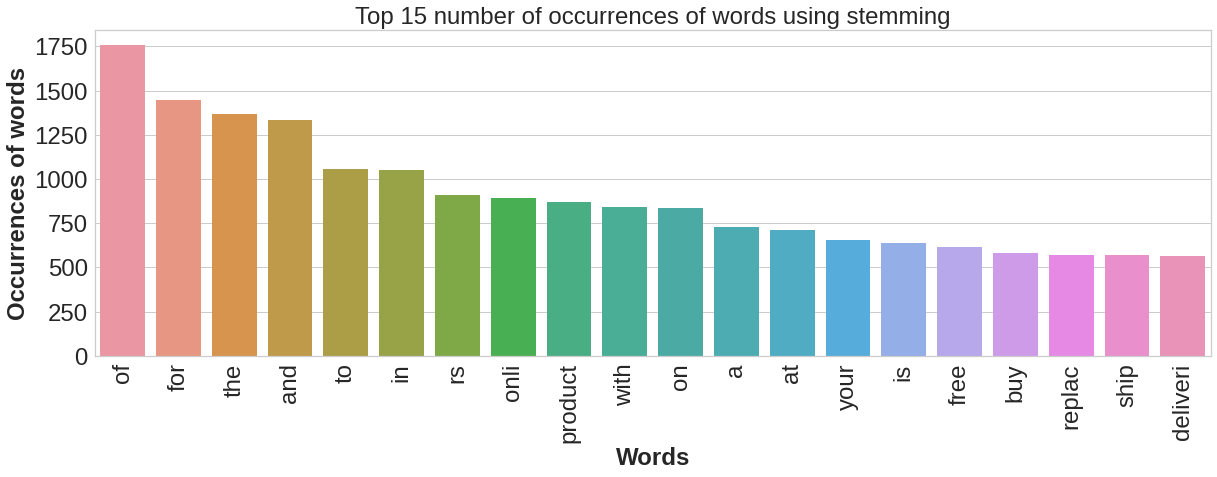

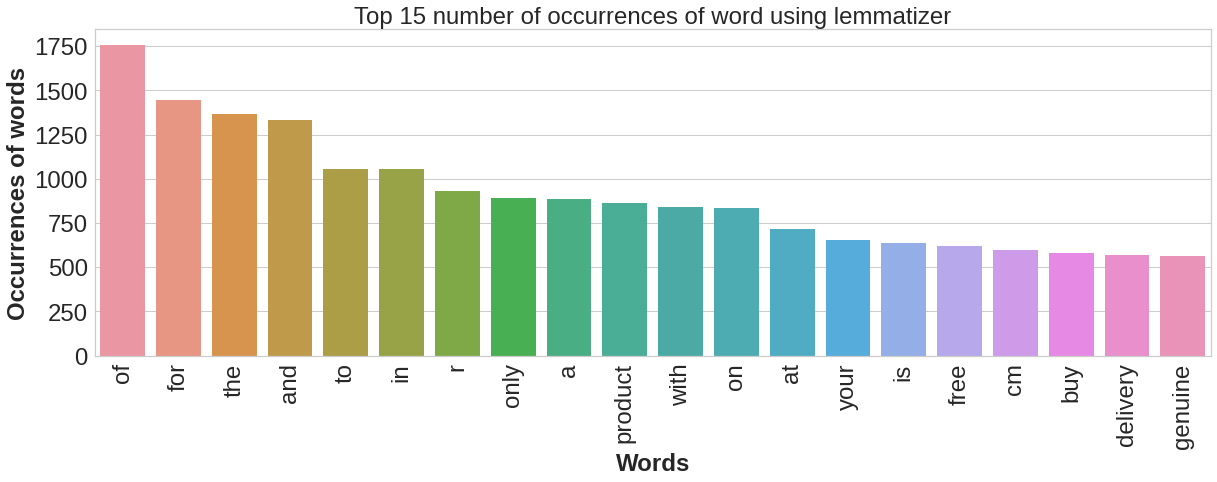

In [27]:
df_mc = pd.DataFrame(mostcommon)
df_mc_l = pd.DataFrame(mostcommon_l)
dss=24

fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x=df_mc[0].head(20), y=df_mc[1].head(20),ax=ax1)
ax1.set_title("Top 15 number of occurrences of words using stemming",size=dss)

ax1.set_ylabel( 'Occurrences of words',weight='bold', size=dss)
ax1.set_xlabel( 'Words', weight='bold', size=dss)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss)
plt.xticks(rotation=90)

plt.savefig('stemming_word.jpeg',format='jpeg',dpi=100,bbox_inches='tight')
!cp "stemming_word.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "stemming_word.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6

fig, ax2 = plt.subplots(figsize=(20,6))
sns.barplot(x=df_mc_l[0].head(20), y=df_mc_l[1].head(20),ax=ax2)
ax2.set_title("Top 15 number of occurrences of word using lemmatizer", size=dss)

ax2.set_ylabel( 'Occurrences of words',weight='bold', size=dss)
ax2.set_xlabel( 'Words', weight='bold', size=dss)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss)
plt.xticks(rotation=90)


plt.savefig('lemmatizer_word.jpeg',format='jpeg',dpi=100,bbox_inches='tight')
!cp "lemmatizer_word.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "lemmatizer_word.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


<b> Remarque: </b> Pas de différence majeur entre le résultat de la méthode  lemmatizing et stemming

In [28]:
df[new_tokens_var+str('stem')] = df[new_tokens_var+str('stem')].apply(lambda x: [s for s in x if s not in sw])
df[new_tokens_var+str('lemm')] = df[new_tokens_var+str('lemm')].apply(lambda x: [s for s in x if s not in swl])

In [29]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [30]:
no_features=10000
no_topics = 5
no_top_words = 10
max_df=0.95
min_df=0.05
rstate=10

<b> Count Vectorizer </b>  est un moyen de convertir un ensemble données de chaînes de caractères en une représentation fréquentielle. \
<b> TFIDF Vectorizer</b> est une statistique basée sur la fréquence d'un mot dans le corpus, mais elle fournit également une représentation numérique de l'importance d'un mot pour l'analyse statistique. \

TFIDF Vectorizer est meilleur que  Count Vectorizer car il ne se concentre pas seulement sur la fréquence des mots présents dans le corpus mais fournit également l'importance des mots. Nous pouvons alors éliminer les mots qui sont moins importants pour l'analyse, ce qui rend la construction du modèle moins complexe en réduisant les dimensions d'entrée

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_df=max_df,  min_df=min_df, stop_words=sw)
tfidf = tfidf_vectorizer.fit_transform(df[new_tokens_var+str('stem')].apply(lambda x: " ".join(x))).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
TfidfVec=pd.DataFrame(tfidf,columns=tfidf_feature_names)

Cv_vectorizer = CountVectorizer(max_df=max_df,  min_df=min_df, stop_words=sw)
Cv = Cv_vectorizer.fit_transform(df[new_tokens_var+str('stem')].astype(str))
Cv_feature_names = Cv_vectorizer.get_feature_names()
CountVec=pd.DataFrame(Cv.toarray(),columns=Cv_feature_names)

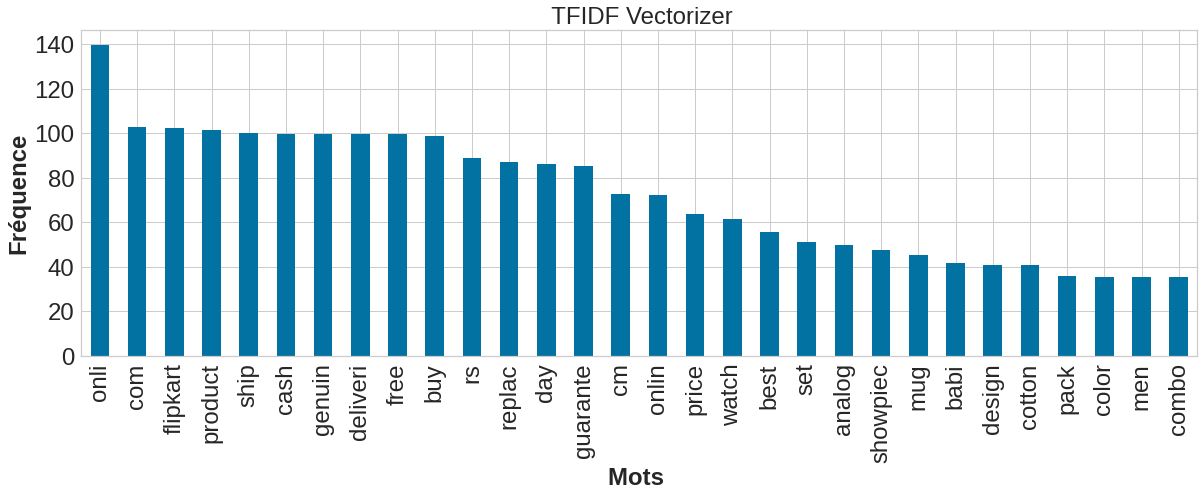

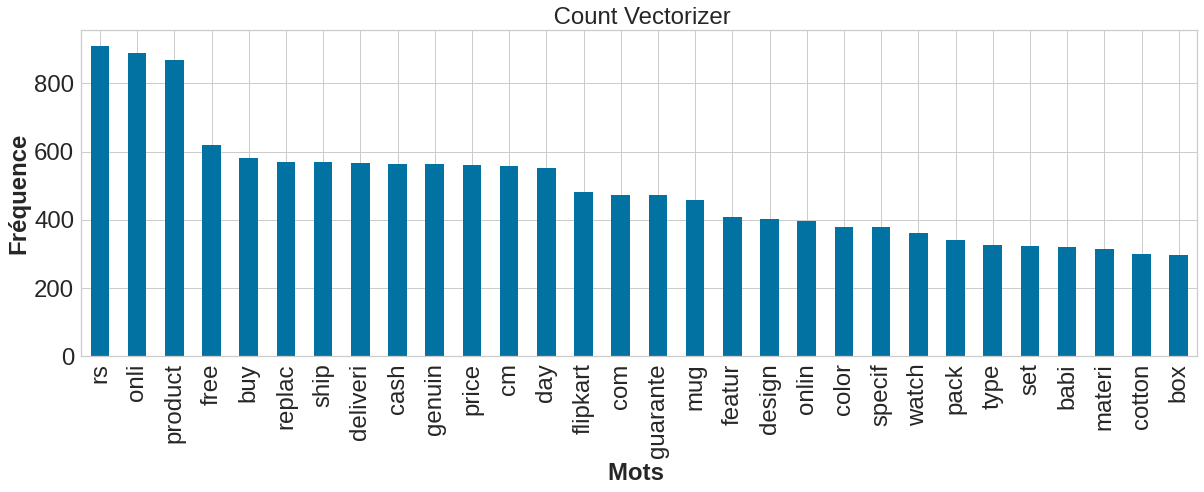

In [32]:
fig, ax2 = plt.subplots(figsize=(20,6))
TfidfVec.sum().sort_values(ascending=False).head(30).plot.bar(ax=ax2)

ax2.set_title(" TFIDF Vectorizer", size=dss)
ax2.set_ylabel('Fréquence', weight='bold', size=dss)
ax2.set_xlabel('Mots ', weight='bold', size=dss)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss)

plt.savefig('TFIDF_vect.jpeg',format='jpeg',dpi=100,bbox_inches='tight')
!cp "TFIDF_vect.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "TFIDF_vect.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


fig, ax2 = plt.subplots(figsize=(20,6))
CountVec.sum().sort_values(ascending=False).head(30).plot.bar(ax=ax2)
ax2.set_title(" Count Vectorizer", size=dss)
ax2.set_ylabel('Fréquence', weight='bold', size=dss)
ax2.set_xlabel('Mots ', weight='bold', size=dss)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss)


plt.savefig('Count_vect.jpeg',format='jpeg',dpi=100,bbox_inches='tight')
!mv "Count_vect.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6

<b> Remarque ?????: </b> Même pattern, mais la fréquence des mot differ.


In [33]:
scaler = preprocessing.StandardScaler()

# # transform data
TfidfVec = scaler.fit_transform(TfidfVec)
CountVec = scaler.fit_transform(CountVec)

TfidfVec = pd.DataFrame(data=TfidfVec)
CountVec = pd.DataFrame(data=CountVec)

In [34]:
var_explained=0.75

def pca_red_dim(model_res,var_explained):
    pca = PCA(var_explained)  
    df_PCA = pca.fit_transform(model_res)
    num_pc = len(pca.components_) 
    pc_list = [str(i) for i in list(range(1, num_pc+1))] #["PC"+str(i) for i in list(range(1, num_pc+1))]
    X_pca   = pca.transform(model_res)
    return pc_list,pca,X_pca

In [35]:
def display_scree_plot(pca,pc_list,ax):
    scree = pca.explained_variance_ratio_*100
    ax.bar(pc_list, scree, alpha=0.5, align='center', label='individual explained variance')
    ax.step(pc_list,  scree.cumsum(),c="red",marker='o',where= 'mid', label='cumulative explained variance')
    ax.set_xlabel("PCs")
    ax.set_ylabel("Ratio de la variance expliqué")
    ax.legend(loc = 'best')

In [36]:
[cv_pc,cv_pca,cv_X_pca] = pca_red_dim(CountVec,var_explained)
[tfidf_pc,tfidf_pca,tfidf_X_pca] = pca_red_dim(TfidfVec,var_explained)
print('CountVec ---->  Size before PCA',CountVec.shape,'---- Size after PCA',cv_X_pca.shape)
print('TfidfVec ---->  Size before PCA',TfidfVec.shape,'---- Size after PCA',tfidf_X_pca.shape)

CountVec ---->  Size before PCA (1050, 107) ---- Size after PCA (1050, 28)
TfidfVec ---->  Size before PCA (1050, 107) ---- Size after PCA (1050, 32)


In [37]:
def fig_pca(X_PCA,df,ax):
    chaine = "Plan factoriel pour les composantes 1 et 2 de l'ACP"
    ax.set_title(chaine)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")

    sns.scatterplot(
        x=X_PCA[:,0],
        y=X_PCA[:,1],
        hue=df['Category_0'],ax=ax,
        alpha=0.8,
        s=30
    )

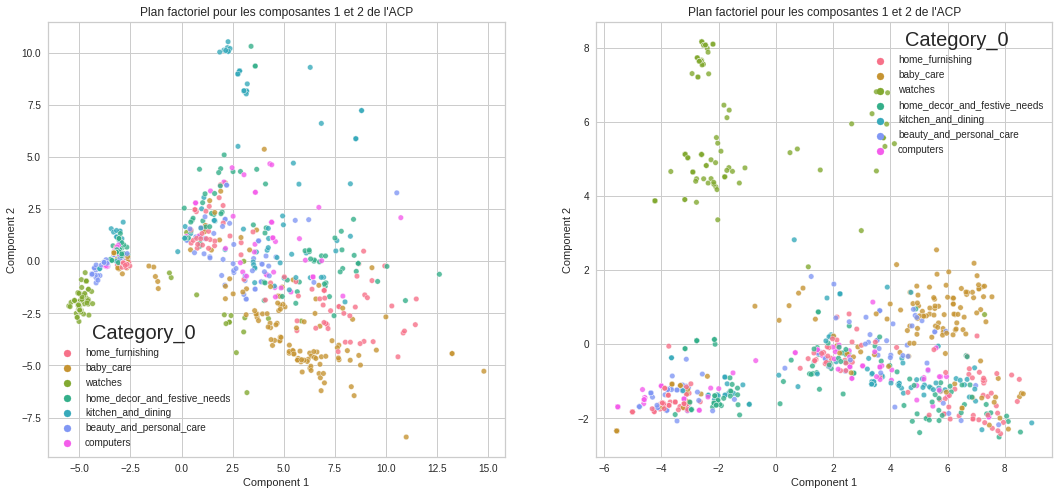

In [38]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,8))
fig_pca(cv_X_pca,df,ax1)
fig_pca(tfidf_X_pca,df,ax2)

In [39]:
tsne = TSNE(n_components=2, init="pca")
X_tsne_cv  = tsne.fit_transform(cv_X_pca)
X_tsne_tfidf  = tsne.fit_transform(tfidf_X_pca)

In [40]:
df_tsne_tfidf = pd.DataFrame(X_tsne_tfidf[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_tfidf["class"] = df['Category_0']
print(df_tsne_tfidf.shape)
df_tsne_cv = pd.DataFrame(X_tsne_cv[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_cv["class"] = df['Category_0']
print(df_tsne_cv.shape)

(1050, 3)
(1050, 3)


In [41]:
def plot_tsne(df,ax):
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", data=df, ax=ax,legend="brief",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    ax.set_title('TSNE selon les vraies classes', fontweight = 'bold')
    ax.set_xlabel('tsne1')
    ax.set_ylabel('tsne2')

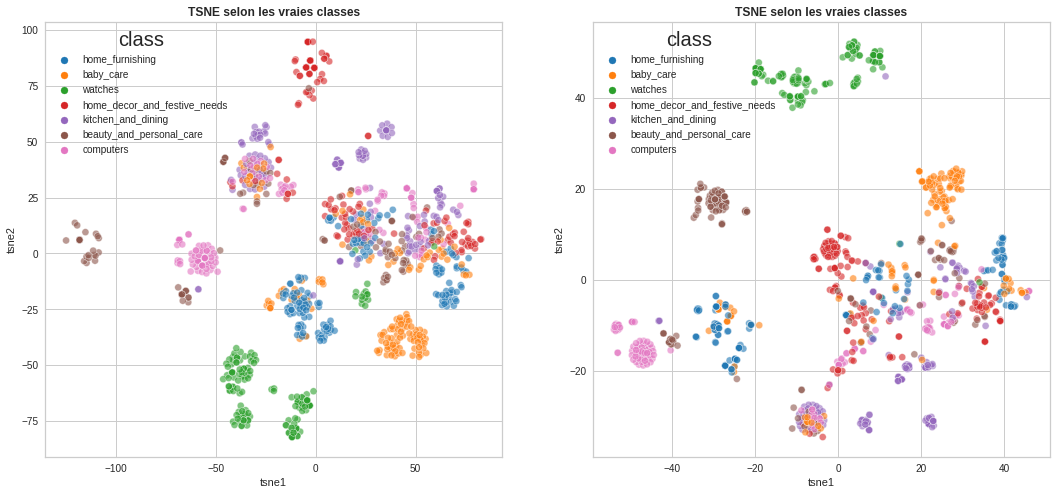

In [42]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,8))
plot_tsne(df_tsne_cv,ax1)
plot_tsne(df_tsne_tfidf,ax2)

# Application de la répartition des points de données en k groupes différents (k-means clustering)

In [43]:
def find_optimal_K(rstate,df):
    #
    visualizer = KElbowVisualizer(KMeans(random_state=rstate))
    visualizer.fit(df)
    
    # Trouver le nombre optimal de clusters
    nclusters= visualizer.__dict__['elbow_value_']
    
    return nclusters


def stability_measure(nclusters,df):
    inx=0
    inx0=0
    inj=0
    df_stability=pd.DataFrame()
    #
    for knx in range(0,nclusters*3): 
        knx=nclusters
        kmeans_visualizer = KMeans(n_clusters=knx,init='random')
        kmeans_visualizer.fit(df)
        name1='Iteration  '+str(inj)
        df_stability[name1]=kmeans_visualizer.predict(df)
    
        inj0=inj-1
        if inj==0:
            name0=name1
            inj0=inj
        ARI_RFM_KMeans=adjusted_rand_score(df_stability[name1],df_stability[name0])
        print('ARI  '+ str(name1) + ' - ' + str(name0)+'     =  ' , ARI_RFM_KMeans ) 
        name0=name1
        inj=inj+1  
    return df_stability

def final_KMeans_model(df,nclusters,nstate):
    kmeans_visualizer = KMeans(n_clusters=nclusters,random_state=nstate)
    kmeans_visualizer.fit(df)
    name='Cluster = '+str(nclusters)
    df[name]=kmeans_visualizer.predict(df)
    labels =kmeans_visualizer.labels_
    centers=kmeans_visualizer.cluster_centers_
    return df,labels,centers,name ,kmeans_visualizer

def pca_dim_reduction(df,var_explaned,figure_name ):
    pcamodel=decomposition.PCA(var_explaned)
    pcamodel.fit(df)
    explained_var=pcamodel.explained_variance_ratio_
    explained=pcamodel.explained_variance_ratio_.cumsum()
    loadings = pcamodel.components_
    num_pc = len(pcamodel.components_) 
    pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
#
    loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    loadings_df['variable'] = df.columns.values
    loadings_df = loadings_df.set_index('variable')
    
    df_dim_red=pcamodel.transform(df)
    df_dim_red = pd.DataFrame(data=df_dim_red, columns=pc_list)

    f, (ax1) = plt.subplots(1,1, figsize=(18,8))
    display_scree_plot(pcamodel,pc_list,ax1)

    plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')
    
    return df_dim_red,pcamodel

def myplot(data,x_scaled,name1,pca,dim,boundary,alpha,labels=None):
    fig, ax = plt.subplots(figsize=(15,8))
    
    d1=dim[0]
    d2=dim[1]
    c=x_scaled[name1]
    coeff=np.transpose(pca.components_[d1:d2+1, :])
    score=data.values 
    xs = score[:,d1]
    ys = score[:,d2]
    n = coeff.shape[0]
    value=np.unique(c)
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    ass=ax.scatter(xs * scalex,ys * scaley,c=c.astype(float),cmap='Paired',s=50, alpha=alpha)
    ax.set_xlim([-boundary,boundary])
    ax.set_ylim([-boundary,boundary])
    legend1 = ax.legend(*ass.legend_elements(),
                    bbox_to_anchor=(1.05, 1),loc="upper left", title=name1)
    ax.add_artist(legend1)
  
    ax.set_xlabel("PC{} ({}%)".format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    ax.set_ylabel("PC{} ({}%)".format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
       
    ax.axvline(0,color='grey', ls='--') 
    ax.axhline(0,color='grey', ls='--')
    ax.grid()

In [44]:
fid=1
if fid==0:
    data4KM= X_tsne_cv  #CountVec  #
else:
    data4KM= X_tsne_tfidf # TfidfVec  #   #tfidf_X_pca #on reduisant le dimention avec pca, on pert de l'information

data4KM = pd.DataFrame(data=data4KM)

Le nombre optimal de clusters est 4


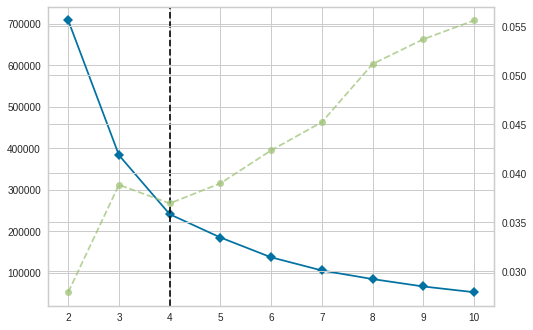

In [45]:
nclusters_cv=find_optimal_K(rstate,data4KM)
print("Le nombre optimal de clusters est",nclusters_cv) 

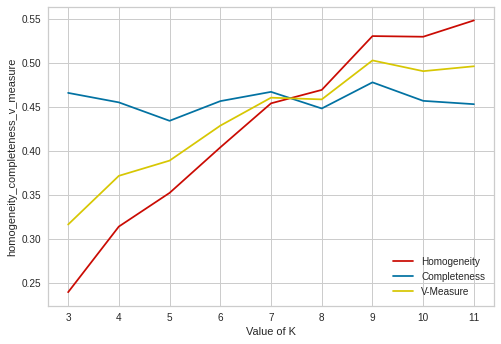

In [46]:
k = range(3,12)
scores = []
 
for n_cluster in k:
    y_pred = KMeans(n_clusters = n_cluster, max_iter=1000, random_state=47).fit_predict(data4KM)
    score = metrics.homogeneity_completeness_v_measure(df['lab_category'], y_pred)
    scores.append(score)
            
# plotting the scores against the value of k
plt.plot(k, [s[0] for s in scores], 'r', label='Homogeneity')
plt.plot(k, [s[1] for s in scores], 'b', label='Completeness')
plt.plot(k, [s[2] for s in scores], 'y', label='V-Measure')
plt.xlabel('Value of K')
plt.ylabel('homogeneity_completeness_v_measure')
plt.legend(loc=4)
plt.show()

In [47]:
nclusters_cv=7

<b> OPTIMAL K LOWER THAN THE CATEGORIES. SHOULD i USE k=NUMBER OF CATEGORIES?????</b>

In [48]:
x_stability = stability_measure(nclusters_cv,data4KM)

ARI  Iteration  0 - Iteration  0     =   1.0
ARI  Iteration  1 - Iteration  0     =   1.0
ARI  Iteration  2 - Iteration  1     =   1.0
ARI  Iteration  3 - Iteration  2     =   1.0
ARI  Iteration  4 - Iteration  3     =   1.0
ARI  Iteration  5 - Iteration  4     =   1.0
ARI  Iteration  6 - Iteration  5     =   1.0
ARI  Iteration  7 - Iteration  6     =   0.9973922715411268
ARI  Iteration  8 - Iteration  7     =   0.7313006862341106
ARI  Iteration  9 - Iteration  8     =   0.7309092175147935
ARI  Iteration  10 - Iteration  9     =   0.9973922715411268
ARI  Iteration  11 - Iteration  10     =   0.9973922715411268
ARI  Iteration  12 - Iteration  11     =   0.9922996030165422
ARI  Iteration  13 - Iteration  12     =   0.9922996030165422
ARI  Iteration  14 - Iteration  13     =   1.0
ARI  Iteration  15 - Iteration  14     =   0.7309092175147935
ARI  Iteration  16 - Iteration  15     =   0.7309092175147935
ARI  Iteration  17 - Iteration  16     =   1.0
ARI  Iteration  18 - Iteration  17     =

In [49]:
[x_cv,labels,centers,name2,kmeans_visualizer] = final_KMeans_model(data4KM,nclusters_cv,rstate)

In [50]:
X=x_cv.drop([name2],axis=1)

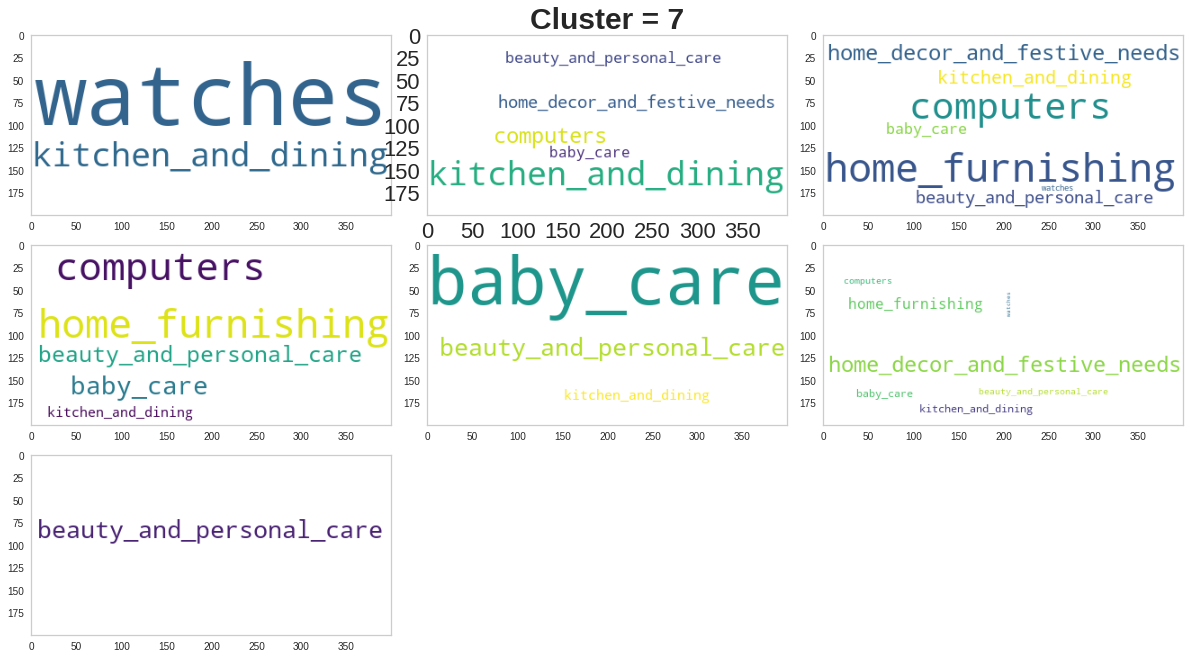

In [51]:
x_cv['Category_0']=df['Category_0']
fig = plt.figure(figsize=(20,20))
for i in range(0,len(x_cv[name2].unique())):
    lab1=x_cv[x_cv[name2]==i]
    wordstring=" ".join(lab1["Category_0"])
    ax = fig.add_subplot(3,3,i+1)
    wrdcloud=WordCloud(background_color='white',
                      max_font_size = 100,
                      collocations=False).generate(wordstring)
    ax.imshow(wrdcloud)
    ax.axis('on')
    ax.grid(False)
    if i==1:
        ax.set_title(name2, weight='bold', size=dss+6)
                
        plt.xticks(fontsize=dss-2)
        plt.yticks(fontsize=dss-2)

fig.subplots_adjust(left=0.1,bottom=.6, right=0.9, top=1.1, wspace=0.1, hspace=-0.3)

In [52]:
from sklearn.metrics import precision_score, accuracy_score,recall_score, davies_bouldin_score
ARI_CAT_KMeans=adjusted_rand_score(df['lab_category'],x_cv[name2])
silhouette_CAT_KMeans = silhouette_score(data4KM.drop(['Category_0',name2],axis=1), labels=x_cv[name2])
dabouldin= davies_bouldin_score(data4KM.drop(['Category_0',name2],axis=1), labels=x_cv[name2])

accuracy = accuracy_score( df['lab_category'],x_cv[name2])
precision= precision_score(df['lab_category'],x_cv[name2], average='weighted')

algo_Performance={"Algorithme": "Kmeans",'accuracy':accuracy ,'precision':precision}
PerformanceK = pd.DataFrame( algo_Performance,
        index=[0],
    )

PerformanceK

Algorithme  accuracy  precision
0     Kmeans      0.02       0.02

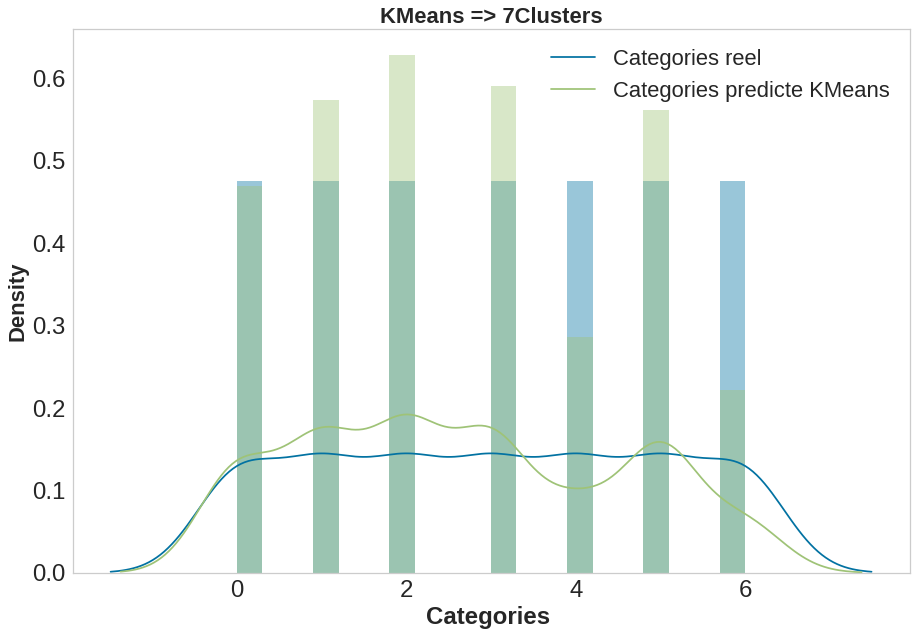

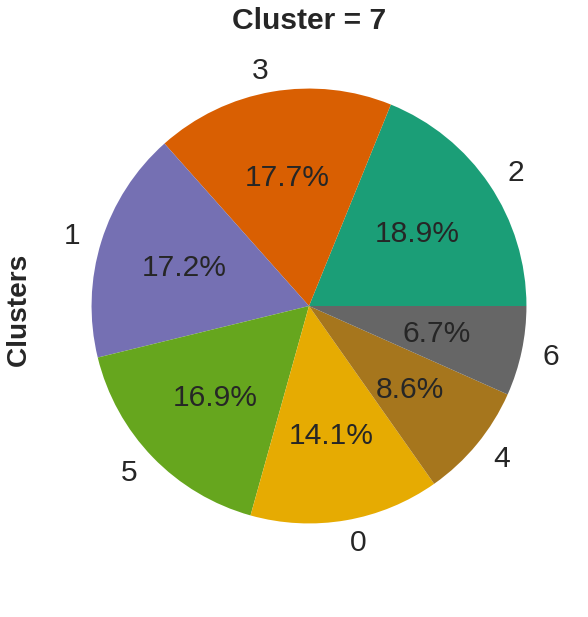

In [53]:

tnx=0
names=["Density_kmeans.jpeg", "KMeans_pie.jpeg"]
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(df['lab_category'], bins=20, rug=False,ax=ax)
ax.set_title('KMeans => '+ str(nclusters_cv) + 'Clusters', weight='bold', size=dss-2)
sns.distplot(x_cv[name2], bins=20, rug=False,ax=ax)
ax.set_xlabel("Catégories")
ax.legend(['Categories reel', 'Categories predicte KMeans'], fontsize=dss-2)

ax.set_ylabel('Density', weight='bold', size=dss-2)
ax.set_xlabel('Categories ', weight='bold', size=dss)
plt.grid(False)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss) 
figure_name=names[tnx]
        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

tnx=tnx+1
dss=30
fig, ax2 = plt.subplots(figsize=(25,10))
data_plot_0 = x_cv.groupby(name2).agg(Clusters =('Category_0','count'))

data_plot_0=data_plot_0.sort_values(by='Clusters', ascending=False)
data_plot_0.plot(kind='pie', x=name2, y='Clusters', title = '', 
cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax2,fontsize=dss).set_title(name2,fontsize=dss, weight='bold');

ax2.set_ylabel('Clusters ', weight='bold', size=dss-2)
ax2.set_xlabel(' ', weight='bold', size=dss)
plt.grid(False)
plt.xticks(fontsize=dss)
plt.yticks(fontsize=dss) 
figure_name=names[tnx]

        
plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp "KMeans_pie.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "KMeans_pie.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6
!mv "Density_kmeans.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


In [54]:
cmf = confusion_matrix(df['lab_category'], x_cv[name2])

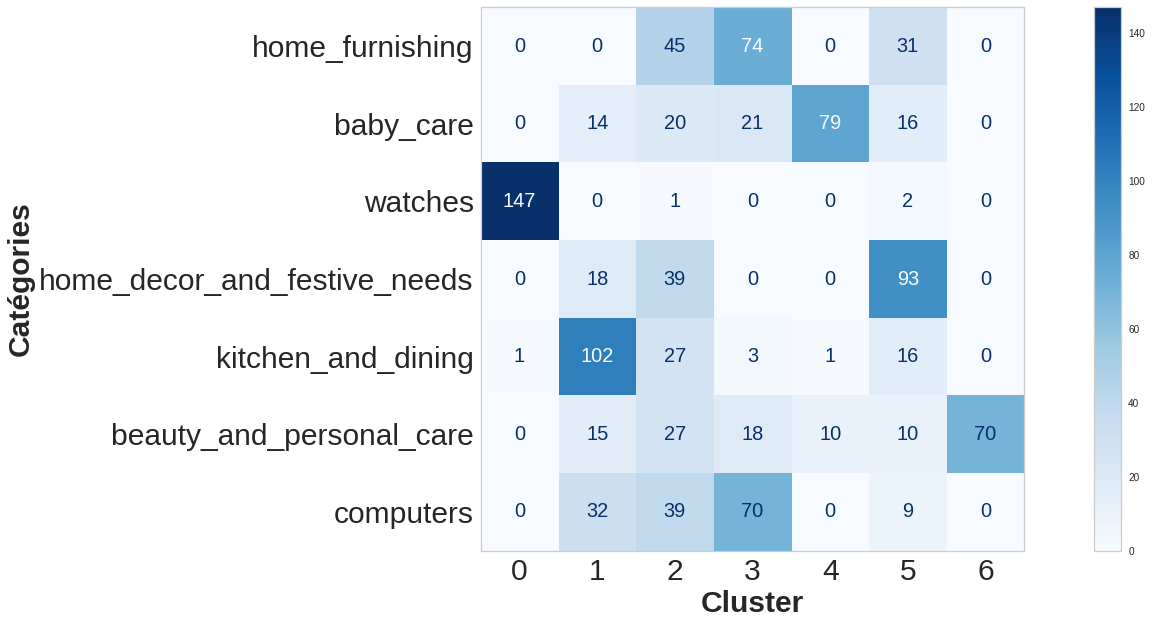

In [55]:
# RAPPEL: lab_category = {'home_furnishing':0, 'baby_care':1,'watches':2,'home_decor_and_festive_needs':3,\
#                 'kitchen_and_dining':4,'beauty_and_personal_care':5,'computers':6}

f, (ax1) = plt.subplots(1,1, figsize=(25,10))
cm_display = ConfusionMatrixDisplay(cmf).plot(ax=ax1,cmap=plt.cm.Blues)
plt.rcParams.update({'font.size': dss})
ax1.set_ylabel("Catégories", weight='bold', size=dss)
ax1.set_xlabel('Cluster', weight='bold', size=dss)
ax1.set_yticklabels(df['Category_0'].unique(), size=dss)
plt.xticks(fontsize=dss)
plt.grid(False)

# Classification supervisée 

In [56]:
Y=df['lab_category']
Cat=data4KM['Category_0']
X=data4KM.drop(['Category_0'],axis=1)

In [57]:
supervise=1
if supervise==1:
    params_Classifiers = {
     "RandomForestClassifier":     {'bootstrap': [True, False],'max_depth': [5,10,20],'max_features': [2, 4],'min_samples_leaf': [2, 4]},  
     'KNeighborsClassifier':       {'n_neighbors': [2,5],'weights': ['uniform','distance']}
    }
    seed = 10
    Classifiers = {
     "RandomForestClassifier": RandomForestClassifier(random_state=seed),
     'KNeighborsClassifier':  KNeighborsClassifier()
    }   
def Multi_output_improved_Classifier_model(Classifiers,params_regressors,X_train, y_train,Cat,n_splits,seed):
    
    results= pd.DataFrame(index=["RMSE",\
                                "best_estimator_","best_params_",'accuracy_score','precision_score']) 
    
    Findex=['Cible predite']    
    frames_train= [] 
    column_Classifier=[]
   
    for ks in Classifiers:
        column_Classifier.append(ks)
#-------------------------------------------------------------------------------------------------------------

    for model_idx in Classifiers:       
        #
        print(model_idx)
        Classifier  = Classifiers[model_idx]
        param_grid= params_Classifiers[model_idx]
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        
        grid_search = GridSearchCV(estimator=Classifier, param_grid=param_grid, cv=kfold)
        
        grid_search.fit(X_train,  y_train)
        
        y_train_pred= grid_search.best_estimator_.predict(X_train)
        train_pred=pd.DataFrame(y_train_pred,index=y_train.index,columns=Findex)
       
        train_rmse=np.sqrt(mean_squared_error(y_train,train_pred)) 
     
        accu=accuracy_score(y_train, y_train_pred)
        prec=precision_score(y_train, y_train_pred, average='weighted')
        
        results[model_idx]=[train_rmse,grid_search.best_estimator_,grid_search.best_params_,accu,prec]
    
        Y_pred_train= pd.concat([y_train,train_pred,Cat],axis=1)
        frames_train.append(Y_pred_train)

    df_pred_train = pd.concat(frames_train, keys=column_Classifier, axis=1)
    
    results=results.T
    
    results=results.sort_values(by=["RMSE"],axis=0, ascending=True)
    return results,df_pred_train

nsplits=10
[eval_results_improved,pred_train_improved]=Multi_output_improved_Classifier_model\
             (Classifiers,params_Classifiers,X,Y,Cat,nsplits,seed)

RandomForestClassifier
KNeighborsClassifier


In [58]:
eval_results_improved.style.background_gradient(axis=None,cmap="coolwarm", subset=['RMSE'])

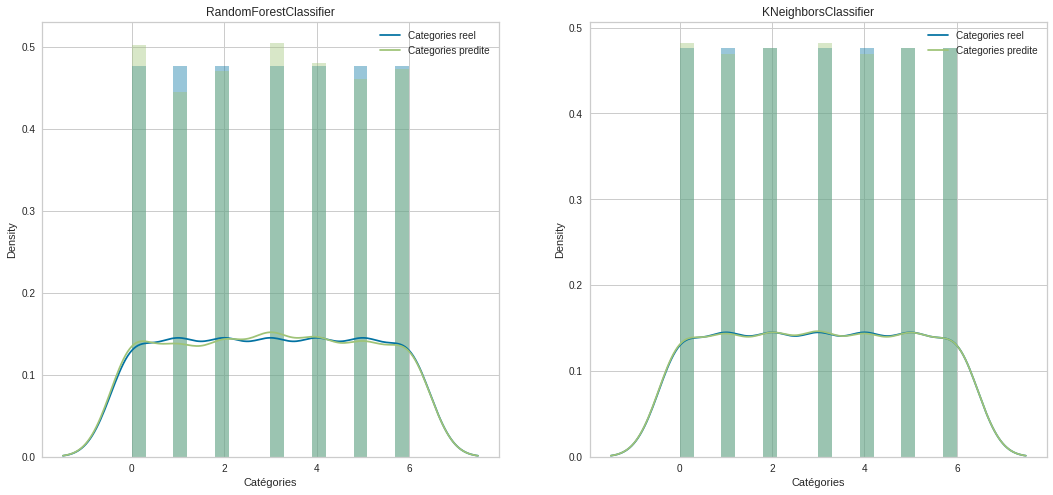

In [59]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,8))
axes=[ax1,ax2]
tnx=0
for knx in Classifiers:
    ax=axes[tnx]
    tnx=tnx+1
    x_cv_data=pred_train_improved[knx]
    sns.distplot(x_cv_data['lab_category'], bins=20, rug=False,ax=ax).set(title=knx)
    sns.distplot(x_cv_data['Cible predite'], bins=20, rug=False,ax=ax)
    ax.set_xlabel("Catégories")
    ax.legend(['Categories reel', 'Categories predite'])

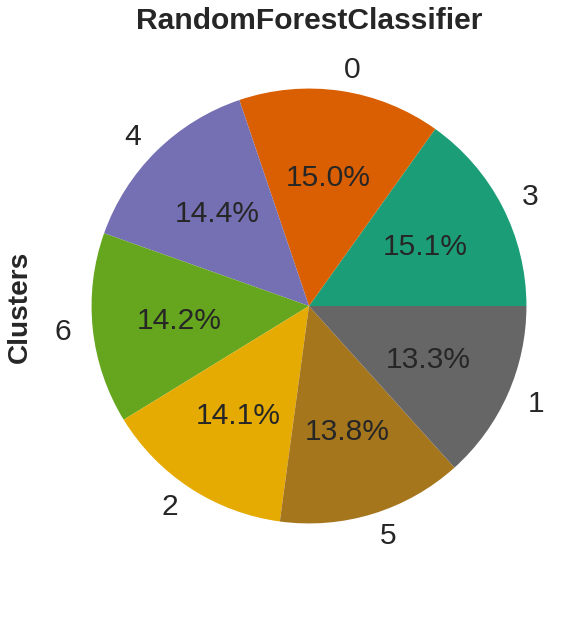

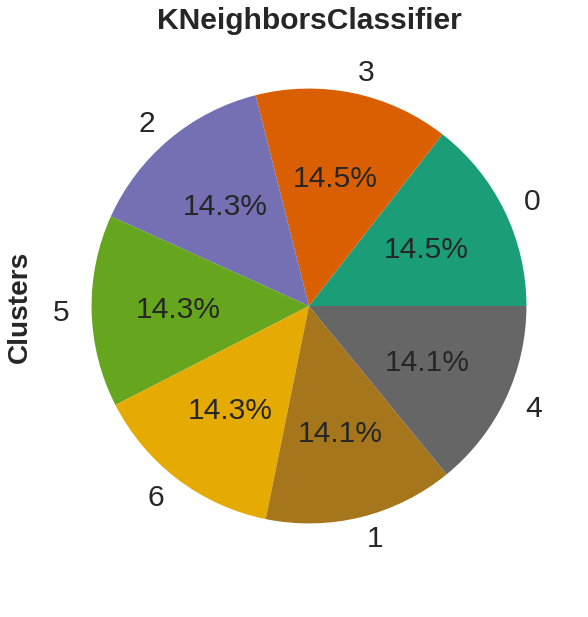

In [60]:
tnx=0
names=["RandomForestClassifier_pie.jpeg", "KNeighborsClassifier_pie.jpeg"]
dss=30
for knx in Classifiers:
        fig, ax2 = plt.subplots(figsize=(25,10))
        x_cv_data=pred_train_improved[knx]
        data_plot_0 = x_cv_data.groupby('Cible predite').agg(Categories =('Category_0','count'))
        data_plot_0 =data_plot_0.sort_values(by='Categories', ascending=False)
        data_plot_0.plot(kind='pie', x='Cible predite', y='Categories', 
        cmap='Dark2', autopct="%.1f%%", legend=False,ax=ax2,fontsize=dss).set_title(knx,fontsize=dss, weight='bold');
        
        ax2.set_ylabel('Clusters', weight='bold', size=dss-2)
        ax2.set_xlabel('   ', weight='bold', size=dss)
        plt.xticks(fontsize=dss)
        plt.grid(False)
        plt.xticks(fontsize=dss) 
        figure_name=names[tnx]
        
        plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')
        tnx=tnx+1
        
!cp "RandomForestClassifier_pie.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "RandomForestClassifier_pie.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6
!cp "KNeighborsClassifier_pie.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "KNeighborsClassifier_pie.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


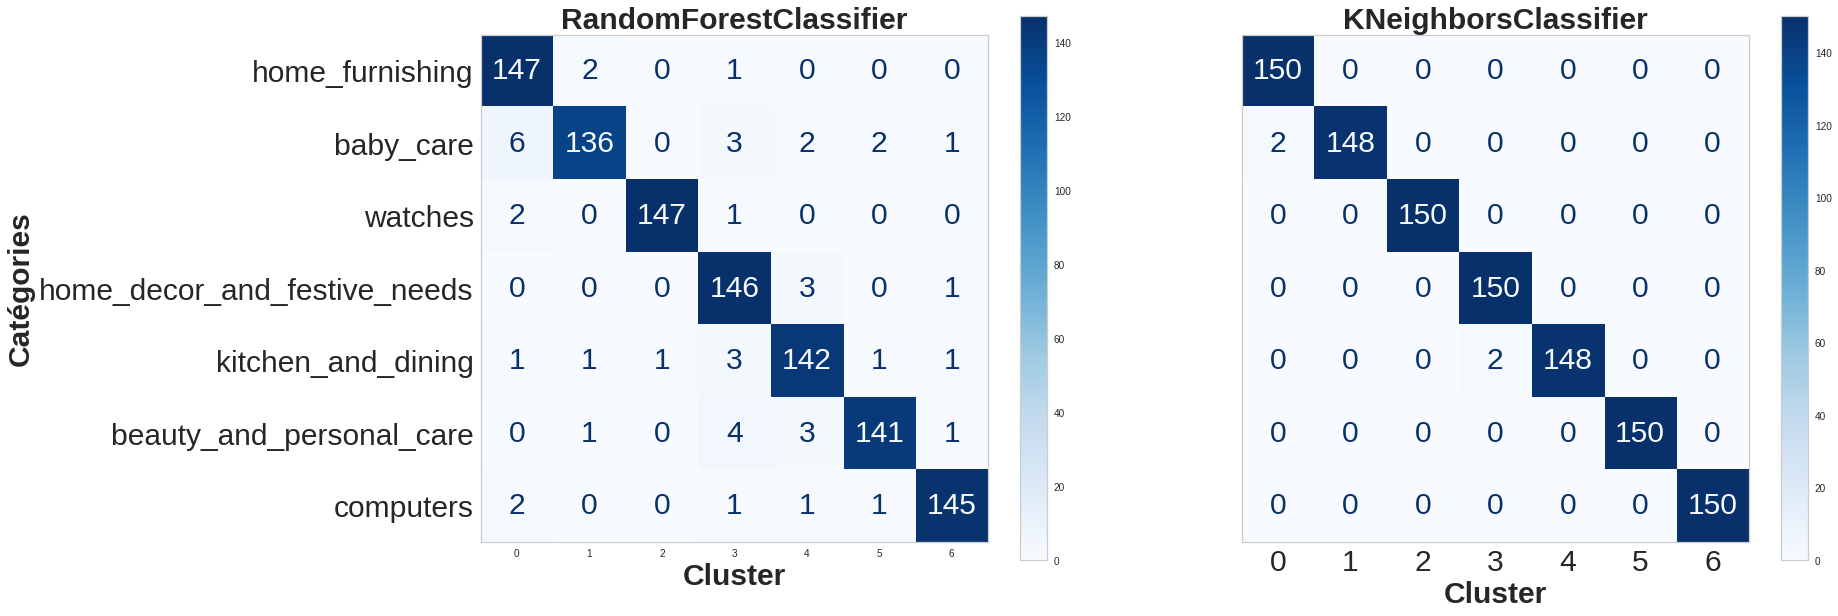

In [61]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(25,10),sharey=True)
tnx=0
axes=[ax1,ax2]
for knx in Classifiers:
    ax=axes[tnx]
    x_cv_data = pred_train_improved[knx]
    cm        = confusion_matrix(x_cv_data['lab_category'],x_cv_data['Cible predite'])
    cm_display= ConfusionMatrixDisplay(cm).plot(ax=ax,cmap=plt.cm.Blues)
    plt.rcParams.update({'font.size': dss})
    ax.set_yticklabels(df['Category_0'].unique(), size=dss)
    if tnx==0:
        ax.set_ylabel("Catégories", weight='bold', size=dss)
    else:  
        ax.set_ylabel(" ", weight='bold', size=dss)
    ax.set_xlabel('Cluster', weight='bold', size=dss)
    ax.set_title(knx, weight='bold', size=dss)
    plt.xticks(fontsize=dss)
    ax.grid(False)
    tnx= tnx+1


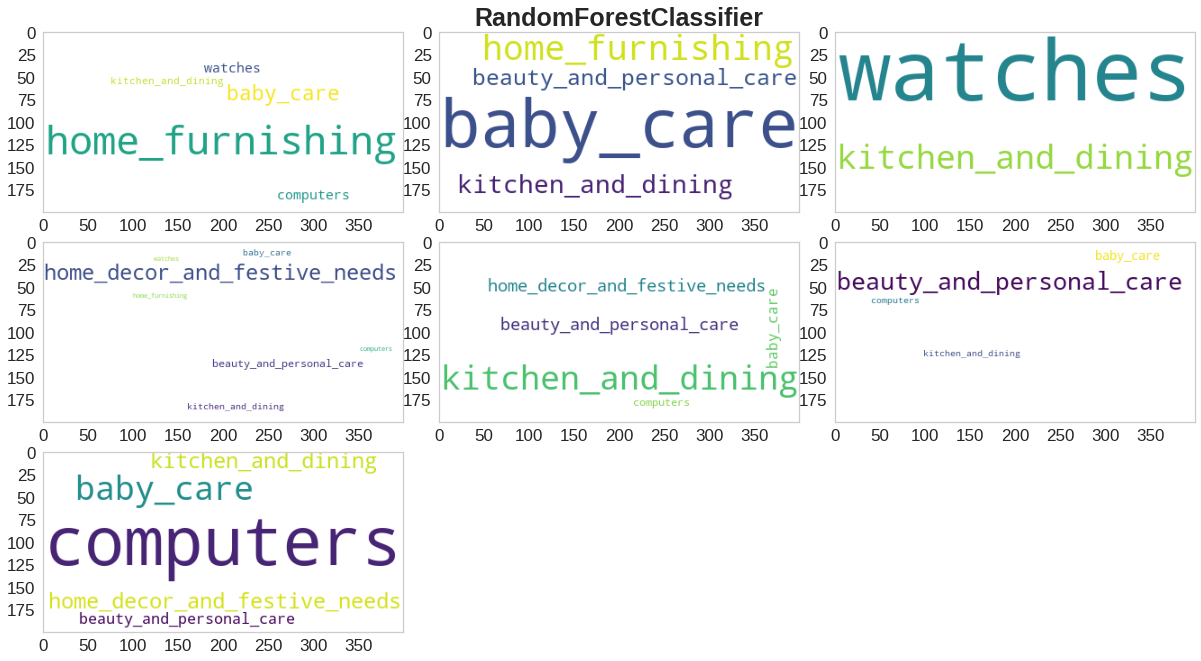

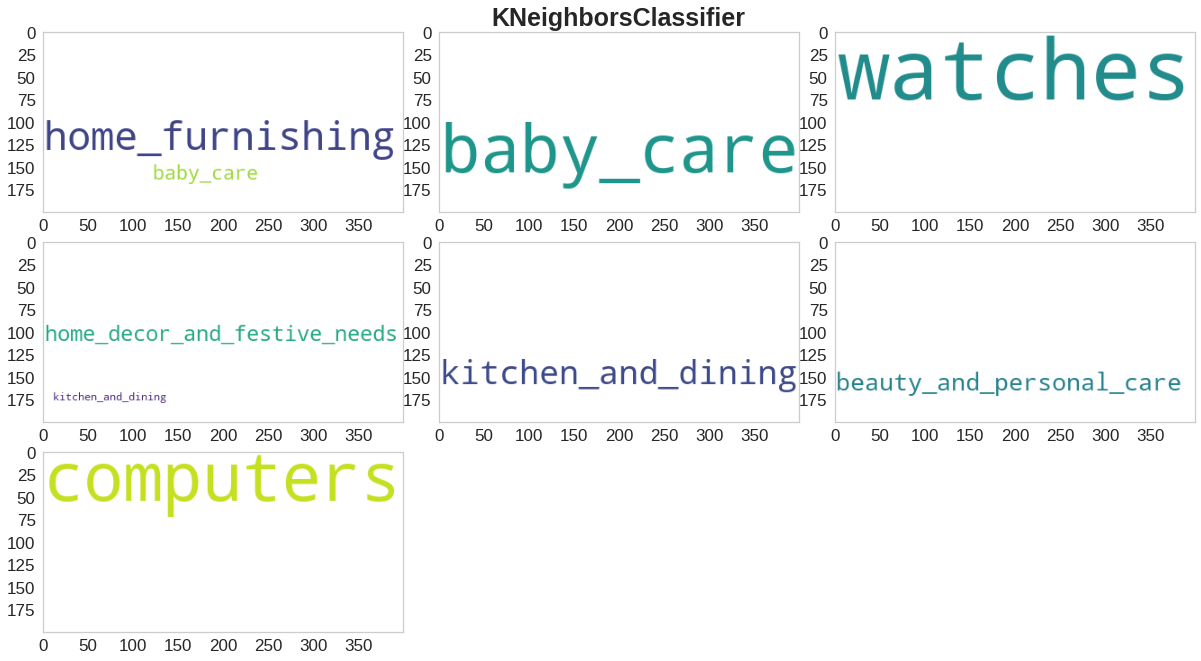

In [62]:
x_cv_data['Category_0']=df['Category_0']

tnx=0
names=["RandomForestClassifier_WordCloud.jpeg", "KNeighborsClassifier_WordCloud.jpeg"]
dss=19
for knx in Classifiers:
    fig = plt.figure(figsize=(20,20))
    x_cv_data = pred_train_improved[knx]
    for i in range(0,len(x_cv_data['Cible predite'].unique())):
        lab1=x_cv_data[x_cv_data['Cible predite']==i]
        wordstring=" ".join(lab1["Category_0"])
            
        ax = fig.add_subplot(3,3,i+1)
        wrdcloud=WordCloud(background_color='white',
                max_font_size = 100,
                collocations=False).generate(wordstring)
        ax.imshow(wrdcloud)
        ax.axis('on')
        ax.grid(False)
        if i==1:
            ax.set_title(knx, weight='bold', size=dss+6)
                
        plt.xticks(fontsize=dss-2)
        plt.yticks(fontsize=dss-2)

    fig.subplots_adjust(left=0.1,bottom=.6, right=0.9, top=1.1, wspace=0.1, hspace=-0.3)
    figure_name=names[tnx]
    tnx= tnx+1
    
    plt.savefig(figure_name,format='jpeg',dpi=100,bbox_inches='tight')

!cp "KNeighborsClassifier_WordCloud.jpeg" /home/yonss/AndroidStudioProjects/mydashboard/Images
!mv "KNeighborsClassifier_WordCloud.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6
!mv "RandomForestClassifier_WordCloud.jpeg"  /home/yonss/Data_Scientist/FIGURE/P6


In [63]:
tnx=0
for knx in Classifiers:
    x_cv_data = pred_train_improved[knx]

    accuracy = accuracy_score( df['lab_category'],x_cv_data['Cible predite'])
    precision= precision_score(df['lab_category'],x_cv_data['Cible predite'], average='weighted')
    
    algo_Performance={"Algorithme": knx, 'accuracy':accuracy ,'precision':precision}
    
    Performance = pd.DataFrame( algo_Performance,index=[tnx])

    if tnx==0:
        df1=PerformanceK.append(Performance, ignore_index=True)
    elif tnx==1:
        df_ARI=df1.append(Performance, ignore_index=True)
        
    tnx=tnx+1

df_ARI

Algorithme  accuracy  precision
0                  Kmeans      0.02       0.02
1  RandomForestClassifier      0.96       0.96
2    KNeighborsClassifier      1.00       1.00

In [64]:
for knx in Classifiers:
    if knx=='RandomForestClassifier':
        Best_NPL=pd.DataFrame(pred_train_improved[knx])

In [65]:
file=str(dir_data) + '/Best_NPL.csv'
df.to_csv(file)

In [66]:
 Best_NPL.head()

lab_category  Cible predite       Category_0
0             0              0  home_furnishing
1             1              1        baby_care
2             1              1        baby_care
3             0              0  home_furnishing
4             0              0  home_furnishing